In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Qwen1.5-1.8B-Chat Fine-tuning

In [2]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth
    !pip install matplotlib nltk pandas seaborn

In [1]:
# Create directories if they don't exist
import os
SAVE_DIR = "/content/drive/MyDrive/legal-rag-assistant/FineTuned-mistral02"
os.makedirs(SAVE_DIR, exist_ok=True)

## Initialize Unsloth and Load Base Model

In [2]:
from unsloth import FastLanguageModel
import torch

# Check CUDA availability
if torch.cuda.is_available():
    print("CUDA is available.")
    print("Device Name:", torch.cuda.get_device_name(0))
    print("CUDA Device Count:", torch.cuda.device_count())
    print("Current Device ID:", torch.cuda.current_device())
else:
    print("CUDA is not available.")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
CUDA is available.
Device Name: Tesla T4
CUDA Device Count: 1
Current Device ID: 0


In [ ]:
# Load the Qwen1.5-1.8B model with 4-bit quantization
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "mistralai/Mistral-7B-Instruct-v0.2",
    max_seq_length = 4096,     # Context length
    load_in_4bit = True,       # Use 4-bit quantization to save memory
    load_in_8bit = False,      # 8-bit uses more memory but is slightly more accurate
    full_finetuning = False,   # We'll use LoRA
    # token = "hf_...",         # Add your HF token if needed
)

# Add LoRA adapters - only updating a small percentage of parameters
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,                    # LoRA attention dimension
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                     "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,           # Alpha parameter for LoRA scaling
    lora_dropout = 0,          # Dropout probability for LoRA layers
    bias = "none",             # We don't adapt bias terms for efficiency
    use_gradient_checkpointing = "unsloth", # "unsloth" uses 30% less VRAM
    random_state = 3407,
    use_rslora = False,        # Not using rank stabilized LoRA
    loftq_config = None,       # Not using LoftQ
)

print("Model loaded successfully!")

==((====))==  Unsloth 2025.5.1: Fast Mistral patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.5.1 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


## Create Optimized Legal System Prompt

In [ ]:
def create_legal_system_prompt():
    """Multilingual, context-grounded prompt for a legal assistant."""
    return (
        "You are LegalAssistant, an AI legal expert specializing in Moroccan law.\n\n"
        "Your responsibilities:\n"
        "1. Always answer using the **language of the user's question** (French, English).\n"
        "2. Base your response **strictly on the provided legal context**.\n"
        "3. If no relevant information is found in the context, say: "
        "\"Based on the provided context, I cannot answer this question.\"\n"
        "4. Cite specific legal articles or references when applicable.\n"
        "5. Avoid any speculation or hallucination. Do not invent facts.\n"
        "6. Respond concisely and clearly. Use bullet points or numbered lists if needed for clarity.\n"
        "7. Be professional and helpful at all times.\n\n"
        "Your goal is to provide **accurate legal information grounded in the context**. Never exceed it."
    )


## Load and Prepare the LLeQA Dataset

In [ ]:
import json
import numpy as np
import pandas as pd
from datasets import Dataset, load_dataset

# Function to load the LLeQA dataset
def load_lleqa_dataset(data_dir="/content/drive/MyDrive/legal-rag-assistant/Notebooks/data/lleqa"):
    """Load the LLeQA dataset from JSON files."""
    questions_train = json.load(open(os.path.join(data_dir, "questions_train.json")))
    questions_dev = json.load(open(os.path.join(data_dir, "questions_dev.json")))
    articles = json.load(open(os.path.join(data_dir, "articles.json")))

    print(f"Loaded {len(questions_train)} training questions")
    print(f"Loaded {len(questions_dev)} dev questions")
    print(f"Loaded {len(articles)} legal articles")

    return {
        "train": questions_train,
        "dev": questions_dev,
        "articles": articles
    }

# Load dataset
data = load_lleqa_dataset()

# Create article lookup dictionary for easy reference
article_lookup = {article["id"]: article for article in data["articles"]}

In [ ]:
def create_legal_qa_conversations(questions, article_lookup, system_prompt=create_legal_system_prompt()):
    conversations = []

    for question in questions:
        # Extract relevant article texts (limit to 3)
        relevant_articles = []
        for article_id in question["article_ids"][:3]:
            article = article_lookup.get(article_id)
            if article:
                reference = article.get("reference", f"Article ID: {article_id}")
                content = article.get("article", "")
                relevant_articles.append(f"{reference}\n{content}")

        context = "\n\n".join(relevant_articles)

        conversations.append([
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"### Question:\n{question['question']}\n\n### Legal context:\n{context}"},
            {"role": "assistant", "content": question['answer']},
        ])

    return {"conversations": conversations}


# Create training dataset
train_data = create_legal_qa_conversations(data["train"], article_lookup)
dev_data = create_legal_qa_conversations(data["dev"], article_lookup)

# Apply chat template
train_conversations = tokenizer.apply_chat_template(
    train_data["conversations"],
    tokenize = False,
)

dev_conversations = tokenizer.apply_chat_template(
    dev_data["conversations"],
    tokenize = False,
)

# Create HuggingFace datasets
train_dataset = Dataset.from_dict({"text": train_conversations})
eval_dataset = Dataset.from_dict({"text": dev_conversations})

print(f"Created training dataset with {len(train_dataset)} examples")
print(f"Created evaluation dataset with {len(eval_dataset)} examples")

# Display a sample
print("\nSample conversation:")
print(train_conversations[0][:1000] + "...")

## Configure and Run Training

In [ ]:
from trl import SFTTrainer, SFTConfig

# Configure GPU memory stats tracking
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

In [ ]:
# Configure the trainer
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    args = SFTConfig(
        dataset_text_field = "text",
        max_seq_length = 4096,
        per_device_train_batch_size = 1,       # Small batch size for limited VRAM
        gradient_accumulation_steps = 8,       # Accumulate gradients to simulate larger batch
        warmup_ratio = 0.03,                   # Gradual learning rate warmup
        num_train_epochs = 1,                  # Adjust based on your needs and time constraints
        learning_rate = 2e-4,                  # Initial learning rate
        logging_steps = 10,                    # Log metrics every 10 steps
        save_steps = 100,                      # Save checkpoint every 100 steps
        optim = "adamw_8bit",                  # 8-bit Adam optimizer to save memory
        weight_decay = 0.01,                   # L2 regularization
        lr_scheduler_type = "cosine",          # Cosine learning rate schedule
        eval_strategy = "steps",         # Evaluate during training
        eval_steps = 100,                      # Evaluate every 100 steps
        save_total_limit = 3,                  # Keep only the 3 best checkpoints
        load_best_model_at_end = True,         # Load best model at the end of training
        seed = 42,
        report_to = "none",                    # Disable reporting to save resources
    ),
)

In [ ]:
# Run training
print("Starting training...")
trainer_stats = trainer.train()

In [ ]:
# Display final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

2166.1301 seconds used for training.
36.1 minutes used for training.
Peak reserved memory = 11.258 GB.
Peak reserved memory for training = 9.344 GB.
Peak reserved memory % of max memory = 76.372 %.
Peak reserved memory for training % of max memory = 63.388 %.


## Test the Fine-tuned Model

In [25]:
# Test the model with a sample legal question
def test_model_response(model, tokenizer, question, context=None):
    """Generate a response from the model for a legal question"""
    system_prompt = create_legal_system_prompt()

    prompt = f"# Question: {question}\n\n# Relevant legal context:\n{context}\n\nPlease answer based only on this information./n/n"

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt}
    ]

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )

    print("Generating response...")

    from transformers import TextStreamer
    inputs = tokenizer(text, return_tensors="pt").to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        temperature=0.3,
        top_p=0.80,
        repetition_penalty=1.2,
        top_k=50,
        streamer=TextStreamer(tokenizer, skip_prompt=True),
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Sample question from the dev set
sample_question = data["dev"][2]
sample_article = article_lookup[sample_question["article_ids"][0]]

print("\n\n===== SAMPLE QUESTION =====")
print(sample_question["question"])
print("\n===== CONTEXT =====")
print(sample_article["article"][:500] + "...")
print("\n===== MODEL RESPONSE =====")
test_model_response(model, tokenizer, sample_question["question"], sample_article["article"])



===== SAMPLE QUESTION =====
Je loue un kot d'étudiant. Quelles règles s'appliquent à mon bail en Wallonie ?

===== CONTEXT =====
Sauf si les parties ont convenu d'une durée inférieure, le bail étudiant est réputé conclu pour une durée d'un an.Il prend fin à l'expiration du terme convenu ou réputé moyennant un préavis d'un mois notifié par l'une ou l'autre partie. Au terme de la durée d'un an, si l'étudiant continue à occuper les lieux sans opposition du bailleur, le bail est prorogé pour une durée d'un an aux mêmes conditions, sans préjudice de l'indexation.Si le bail a été conclu pour une durée inférieure à un an, à défa...

===== MODEL RESPONSE =====
Generating response...


KeyboardInterrupt: 

## Save the Fine-tuned Model for VLLM Compatibility

In [23]:
# Create directory to save the model
os.makedirs(f"{SAVE_DIR}/mistral02-legal-assistant", exist_ok=True)

print("\n===== SAVING THE MODEL =====")
print("Saving model to Google Drive...")

# Step 1: Save LoRA adapters (lightweight)
model.save_pretrained(f"{SAVE_DIR}/mistral02-legal-assistant/lora")
tokenizer.save_pretrained(f"{SAVE_DIR}/mistral02-legal-assistant/lora")
print("LoRA adapters saved successfully!")

# Step 2: Save in float16 for VLLM (compatible with your GTX 1650)
print("Converting to float16 format for VLLM compatibility...")
model.save_pretrained_merged(
    f"{SAVE_DIR}/mistral02-legal-assistant/merged_16bit",
    tokenizer,
    save_method="merged_16bit",
)
print("Float16 model for VLLM saved successfully!")

# Step 3: Save in 4bit format with the correct parameter
print("Converting to 4bit format for more efficient inference...")
model.save_pretrained_merged(
    f"{SAVE_DIR}/mistral02-legal-assistant/merged_4bit",
    tokenizer,
    save_method="merged_4bit_forced",  # Note the _forced suffix here
)
print("4bit model saved successfully!")

print("\n===== MODEL SAVING COMPLETE =====")
print(f"All model versions saved to: {SAVE_DIR}/mistral02-legal-assistant/")


===== SAVING THE MODEL =====
Saving model to Google Drive...


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

LoRA adapters saved successfully!
Converting to float16 format for VLLM compatibility...


Unsloth: Will remove a cached repo with size 1.2K


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 3.25 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 32/32 [03:38<00:00,  6.83s/it]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving /content/drive/MyDrive/legal-rag-assistant/FineTuned-mistral02/mistral02-legal-assistant/merged_16bit/pytorch_model-00001-of-00003.bin...
Unsloth: Saving /content/drive/MyDrive/legal-rag-assistant/FineTuned-mistral02/mistral02-legal-assistant/merged_16bit/pytorch_model-00002-of-00003.bin...
Unsloth: Saving /content/drive/MyDrive/legal-rag-assistant/FineTuned-mistral02/mistral02-legal-assistant/merged_16bit/pytorch_model-00003-of-00003.bin...
Done.
Float16 model for VLLM saved successfully!
Converting to 4bit format for more efficient inference...
Unsloth: Merging 4bit and LoRA weights to 4bit...
This might take 5 minutes...


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/bnb.py:351: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Done.
Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 10 minutes for Llama-7b... Done.
4bit model saved successfully!

===== MODEL SAVING COMPLETE =====
All model versions saved to: /content/drive/MyDrive/legal-rag-assistant/FineTuned-mistral02/mistral02-legal-assistant/


# Qwen1.5-1.8B-Chat model Evaluation

In [ ]:
pip install vllm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.4/326.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/2

In [ ]:
pip install rouge_score

  Using cached rouge_score-0.1.2-py3-none-any.whl


In [ ]:
!pip install bert_score evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.5 MB/s eta 0:00:00


In [ ]:
!pip install datasets==2.11.0 #replace this with the required version

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.16
    Uninstalling multiprocess-0.70.16:
      Successfully uninstalled multiprocess-0.70.16
  Attempting uninstall: datasets
    Found existing installation: datasets 3.6.0
    Uninstalling datasets-3.6.0:
      Successfully uninstalled datasets-3.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

In [ ]:
import json
import time
import os
import numpy as np
import pandas as pd
import torch
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
from rouge_score import rouge_scorer
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import BERTScorer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import evaluate
from datasets import load_metric

# Download nltk resources
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')
nltk.download('wordnet', quiet=True)

INFO 05-08 21:21:52 [__init__.py:239] Automatically detected platform cuda.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Function to create the legal system prompt
def create_legal_system_prompt():
    return """You are LegalAssistant, a professional legal advisor specializing in French and Moroccan law.

When answering questions:
- Base your answers strictly on the provided legal context
- Cite specific articles mentioned in the context
- If information is insufficient, state clearly "Based on the provided context, I don't have enough information to answer this question completely" rather than guessing
- Be concise and direct, avoiding unnecessary elaboration
- Use clear language that non-lawyers can understand
- Structure complex answers with numbered points for clarity
- Maintain a professional, helpful tone throughout

Your goal is to provide accurate legal information without hallucination or speculation."""

# Function to load the LLeQA dataset
def load_lleqa_dataset(data_dir="/content/drive/MyDrive/legal-rag-assistant/Notebooks/data/lleqa"):
    """Load the LLeQA dataset from JSON files."""
    questions_dev = json.load(open(os.path.join(data_dir, "questions_dev.json")))
    articles = json.load(open(os.path.join(data_dir, "articles.json")))

    print(f"Loaded {len(questions_dev)} dev questions")
    print(f"Loaded {len(articles)} legal articles")

    return {
        "dev": questions_dev,
        "articles": articles
    }

# Load the dataset
data = load_lleqa_dataset()

# Create article lookup dictionary
article_lookup = {article["id"]: article for article in data["articles"]}

Loaded 201 dev questions
Loaded 27942 legal articles


In [ ]:
# Path to the fine-tuned model
MODEL_PATH = "/content/drive/MyDrive/legal-rag-assistant/FineTuned-Qwen2/qwen-legal-assistant/merged_16bit"

# Load the tokenizer
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
print("Tokenizer loader successfuly")

# Initialize VLLM
print("Loading model with VLLM...")
llm = LLM(
    model=MODEL_PATH,
    tensor_parallel_size=1,
    gpu_memory_utilization=0.85,
    max_model_len=15000,
    trust_remote_code=True,
)
print("Model loader successfuly")

Loading tokenizer...
Tokenizer loader successfuly
Loading model with VLLM...
INFO 05-08 21:22:22 [config.py:717] This model supports multiple tasks: {'classify', 'generate', 'reward', 'score', 'embed'}. Defaulting to 'generate'.
WARNING 05-08 21:22:22 [arg_utils.py:1658] Compute Capability < 8.0 is not supported by the V1 Engine. Falling back to V0. 
INFO 05-08 21:22:22 [llm_engine.py:240] Initializing a V0 LLM engine (v0.8.5.post1) with config: model='/content/drive/MyDrive/legal-rag-assistant/FineTuned-Qwen2/qwen-legal-assistant/merged_16bit', speculative_config=None, tokenizer='/content/drive/MyDrive/legal-rag-assistant/FineTuned-Qwen2/qwen-legal-assistant/merged_16bit', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=15000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quant

Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 05-08 21:22:42 [loader.py:458] Loading weights took 17.10 seconds
INFO 05-08 21:22:43 [model_runner.py:1140] Model loading took 3.4654 GiB and 17.383823 seconds
INFO 05-08 21:22:46 [worker.py:287] Memory profiling takes 2.45 seconds
INFO 05-08 21:22:46 [worker.py:287] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.85) = 12.53GiB
INFO 05-08 21:22:46 [worker.py:287] model weights take 3.47GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 1.44GiB; the rest of the memory reserved for KV Cache is 7.59GiB.
INFO 05-08 21:22:46 [executor_base.py:112] # cuda blocks: 2592, # CPU blocks: 1365
INFO 05-08 21:22:46 [executor_base.py:117] Maximum concurrency for 15000 tokens per request: 2.76x
INFO 05-08 21:22:49 [model_runner.py:1450] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.

Capturing CUDA graph shapes:   0%|          | 0/35 [00:00<?, ?it/s]

INFO 05-08 21:23:25 [model_runner.py:1592] Graph capturing finished in 35 secs, took 0.16 GiB
INFO 05-08 21:23:25 [llm_engine.py:437] init engine (profile, create kv cache, warmup model) took 42.11 seconds
Model loader successfuly


In [ ]:
# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Initialize BERTScore
print("Loading BERTScore...")
bert_scorer = BERTScorer(lang="fr", rescale_with_baseline=True)

Loading BERTScore...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
# Function to calculate word-based F1 score
def calculate_f1_score(reference, candidate):
    """Calculate F1 score based on word overlap"""
    reference_words = set(nltk.word_tokenize(reference.lower()))
    candidate_words = set(nltk.word_tokenize(candidate.lower()))

    # Calculate precision, recall, F1
    if len(candidate_words) == 0:
        precision = 0.0
    else:
        precision = len(reference_words.intersection(candidate_words)) / len(candidate_words)

    if len(reference_words) == 0:
        recall = 0.0
    else:
        recall = len(reference_words.intersection(candidate_words)) / len(reference_words)

    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * precision * recall / (precision + recall)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [ ]:
# Function to generate response without streaming
def generate_model_response(question, context):
    """Generate a response using VLLM without streaming"""
    system_prompt = create_legal_system_prompt()

    prompt = f"# Question: {question}\n\n# Relevant legal context:\n{context}\n\nPlease answer based only on this information."

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt}
    ]

    # Apply chat template
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
    )

    # Set sampling parameters
    sampling_params = SamplingParams(
        temperature=0.7,
        top_p=0.9,
        top_k=50,
        max_tokens=512,
    )

    # Start timing
    start_time = time.time()

    # Generate without streaming
    outputs = llm.generate(text, sampling_params=sampling_params)
    response = outputs[0].outputs[0].text

    # Calculate timing
    total_time = time.time() - start_time

    # Calculate tokens
    response_tokens = len(tokenizer.encode(response))

    return response, total_time, response_tokens

In [ ]:
# Function to calculate BLEU score
def calculate_bleu(reference, candidate):
    """Calculate BLEU score for a candidate against a reference"""
    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())

    # BLEU requires a list of references (each being a list of tokens)
    references = [reference_tokens]

    # Apply smoothing
    smoothie = SmoothingFunction().method1

    try:
        score = sentence_bleu(references, candidate_tokens, smoothing_function=smoothie)
        return score
    except Exception as e:
        print(f"Error calculating BLEU: {str(e)}")
        return 0.0

In [ ]:
# Function to estimate faithfulness
def estimate_faithfulness(response, context):
    """Estimate faithfulness of response to context"""
    # Simple heuristic: Check what percentage of sentences in the response
    # have some overlap with sentences in the context
    response_sents = nltk.sent_tokenize(response.lower())
    context_sents = nltk.sent_tokenize(context.lower())

    # Convert to word sets for comparison
    context_words = set()
    for sent in context_sents:
        context_words.update(set(nltk.word_tokenize(sent)))

    supported_sents = 0
    for sent in response_sents:
        sent_words = set(nltk.word_tokenize(sent))
        overlap = len(sent_words.intersection(context_words))
        if overlap > 3:  # If at least 3 words overlap
            supported_sents += 1

    # Get faithfulness score
    if len(response_sents) > 0:
        faithfulness_score = supported_sents / len(response_sents)
    else:
        faithfulness_score = 0.0

    return faithfulness_score

In [ ]:
# Function to calculate metrics
def calculate_metrics(reference, candidate, context):
    """Calculate all metrics"""
    # ROUGE scores
    rouge_scores = scorer.score(reference, candidate)

    # BLEU score
    bleu_score = calculate_bleu(reference, candidate)

    # BERTScore
    _, _, bert_f1 = bert_scorer.score([candidate], [reference])

    # Word F1 score
    word_f1 = calculate_f1_score(reference, candidate)

    # Faithfulness estimate
    faithfulness = estimate_faithfulness(candidate, context)

    # Token count
    candidate_tokens = len(tokenizer.encode(candidate))
    reference_tokens = len(tokenizer.encode(reference))

    return {
        'rouge1_precision': rouge_scores['rouge1'].precision,
        'rouge1_recall': rouge_scores['rouge1'].recall,
        'rouge1_fmeasure': rouge_scores['rouge1'].fmeasure,
        'rouge2_precision': rouge_scores['rouge2'].precision,
        'rouge2_recall': rouge_scores['rouge2'].recall,
        'rouge2_fmeasure': rouge_scores['rouge2'].fmeasure,
        'rougeL_precision': rouge_scores['rougeL'].precision,
        'rougeL_recall': rouge_scores['rougeL'].recall,
        'rougeL_fmeasure': rouge_scores['rougeL'].fmeasure,
        'bleu': bleu_score,
        'bert_score': bert_f1.item(),
        'word_f1': word_f1['f1'],
        'faithfulness': faithfulness,
        'candidate_tokens': candidate_tokens,
        'reference_tokens': reference_tokens,
    }

In [ ]:
# Evaluate model on a sample of dev questions
def evaluate_on_samples(num_samples=10, random_seed=42):
    """Evaluate the model on a sample of questions from the dev set"""
    # Set random seed for reproducibility
    np.random.seed(random_seed)

    # Take a random sample of questions
    if num_samples >= len(data['dev']):
        sample_questions = data['dev']
    else:
        sample_idx = np.random.choice(len(data['dev']), size=num_samples, replace=False)
        sample_questions = [data['dev'][i] for i in sample_idx]

    results = []

    for i, question in enumerate(tqdm(sample_questions, desc="Evaluating questions")):
        question_text = question["question"]
        reference_answer = question["answer"]

        # Get relevant articles for the question
        relevant_articles = []
        for article_id in question["article_ids"]:
            if article_id in article_lookup:
                article_text = article_lookup[article_id]["article"]
                article_ref = article_lookup[article_id].get("reference", f"Article ID: {article_id}")
                relevant_articles.append(f"{article_ref}\n{article_text}")

        # Combine relevant article text (limit to first 2 articles to avoid context length issues)
        context = "\n\n".join(relevant_articles[:2])

        # Generate model response
        response, generation_time, response_tokens = generate_model_response(question_text, context)

        # Calculate metrics
        metrics = calculate_metrics(reference_answer, response, context)

        # Store results
        result = {
            'question_id': question.get('id', i),
            'question': question_text,
            'reference_answer': reference_answer,
            'model_response': response,
            'generation_time': generation_time,
            'response_tokens': response_tokens,
            **metrics
        }
        results.append(result)

        # Print progress information
        print(f"\nQuestion {i+1}/{len(sample_questions)}: {question_text[:80]}...")
        print(f"Generation time: {generation_time:.2f} seconds")
        print(f"Response tokens: {response_tokens}")
        print(f"ROUGE-L F1: {metrics['rougeL_fmeasure']:.4f}")
        print(f"BERTScore: {metrics['bert_score']:.4f}")
        print(f"Faithfulness: {metrics['faithfulness']:.4f}")

    return pd.DataFrame(results)


In [ ]:
# Function to visualize results
def visualize_results(results_df):
    """Create visualizations of the evaluation results"""
    # Set up plotting style
    plt.style.use('ggplot')

    # 1. Summary of all metrics in a single bar chart
    plt.figure(figsize=(12, 8))
    metrics_to_plot = [
        'rouge1_fmeasure', 'rouge2_fmeasure', 'rougeL_fmeasure',
        'bleu', 'bert_score', 'word_f1', 'faithfulness'
    ]

    mean_values = [results_df[metric].mean() for metric in metrics_to_plot]
    metric_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU', 'BERTScore', 'Word F1', 'Faithfulness']

    bars = plt.bar(metric_names, mean_values, color=sns.color_palette("viridis", len(metrics_to_plot)))

    # Add values on top of bars
    for bar, value in zip(bars, mean_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.title('Average Scores Across All Metrics', fontsize=16)
    plt.ylim(0, max(mean_values) + 0.15)
    plt.ylabel('Score', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/legal-rag-assistant/Notebooks/results/generation/summary_metrics.png')
    plt.show()

    # 2. Detailed ROUGE scores (precision, recall, F1)
    plt.figure(figsize=(12, 7))

    metrics_detailed = [
        'rouge1_precision', 'rouge1_recall', 'rouge1_fmeasure',
        'rouge2_precision', 'rouge2_recall', 'rouge2_fmeasure',
        'rougeL_precision', 'rougeL_recall', 'rougeL_fmeasure'
    ]

    mean_values = [results_df[metric].mean() for metric in metrics_detailed]
    metric_names = [
        'R-1 Prec', 'R-1 Rec', 'R-1 F1',
        'R-2 Prec', 'R-2 Rec', 'R-2 F1',
        'R-L Prec', 'R-L Rec', 'R-L F1'
    ]

    # Group by ROUGE type for a grouped bar chart
    x = np.arange(3)
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 7))
    ax.bar(x - width, mean_values[0:3], width, label='ROUGE-1', color='#ff9999')
    ax.bar(x, mean_values[3:6], width, label='ROUGE-2', color='#66b3ff')
    ax.bar(x + width, mean_values[6:9], width, label='ROUGE-L', color='#99ff99')

    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('ROUGE Scores Breakdown', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(['Precision', 'Recall', 'F1'])
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/legal-rag-assistant/Notebooks/results/generation/rouge_breakdown.png')
    plt.show()

    # 3. Response time and length
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Response time histogram
    sns.histplot(results_df['generation_time'], kde=True, bins=10, ax=ax1, color='skyblue')
    ax1.set_title('Response Time Distribution', fontsize=14)
    ax1.set_xlabel('Generation Time (seconds)', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.axvline(x=results_df['generation_time'].mean(), color='red', linestyle='--',
               label=f'Mean: {results_df["generation_time"].mean():.2f}s')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()

    # Response length scatter plot with reference length
    ax2.scatter(results_df['reference_tokens'], results_df['response_tokens'],
               alpha=0.6, color='green')

    # Add line of equality
    max_tokens = max(results_df['reference_tokens'].max(), results_df['response_tokens'].max())
    ax2.plot([0, max_tokens], [0, max_tokens], 'r--', label='Equal Length')

    # Add means
    ax2.axhline(y=results_df['response_tokens'].mean(), color='green', linestyle=':',
               label=f'Avg Response: {results_df["response_tokens"].mean():.1f} tokens')
    ax2.axvline(x=results_df['reference_tokens'].mean(), color='blue', linestyle=':',
               label=f'Avg Reference: {results_df["reference_tokens"].mean():.1f} tokens')

    ax2.set_title('Response vs Reference Length', fontsize=14)
    ax2.set_xlabel('Reference Length (tokens)', fontsize=12)
    ax2.set_ylabel('Response Length (tokens)', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/legal-rag-assistant/Notebooks/results/generation/response_time_length.png')
    plt.show()

    # 4. Correlation between metrics
    plt.figure(figsize=(12, 10))
    correlation_metrics = [
        'rouge1_fmeasure', 'rouge2_fmeasure', 'rougeL_fmeasure',
        'bleu', 'bert_score', 'word_f1', 'faithfulness',
        'generation_time', 'response_tokens'
    ]

    correlation_names = [
        'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU',
        'BERTScore', 'Word F1', 'Faithfulness',
        'Gen. Time', 'Tokens'
    ]

    corr_matrix = results_df[correlation_metrics].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
                xticklabels=correlation_names, yticklabels=correlation_names)
    plt.title('Correlation Between Metrics', fontsize=16)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/legal-rag-assistant/Notebooks/results/generation/metrics_correlation.png')
    plt.show()

    # Calculate and return summary statistics
    summary_stats = {
        'rouge1_f1': results_df['rouge1_fmeasure'].mean(),
        'rouge2_f1': results_df['rouge2_fmeasure'].mean(),
        'rougeL_f1': results_df['rougeL_fmeasure'].mean(),
        'bleu': results_df['bleu'].mean(),
        'bertscore': results_df['bert_score'].mean(),
        'word_f1': results_df['word_f1'].mean(),
        'faithfulness': results_df['faithfulness'].mean(),
        'avg_gen_time': results_df['generation_time'].mean(),
        'avg_tokens': results_df['response_tokens'].mean(),
        'ref_tokens': results_df['reference_tokens'].mean(),
    }

    print("\n===== SUMMARY STATISTICS =====")
    print(f"ROUGE-1 F1:    {summary_stats['rouge1_f1']:.4f}")
    print(f"ROUGE-2 F1:    {summary_stats['rouge2_f1']:.4f}")
    print(f"ROUGE-L F1:    {summary_stats['rougeL_f1']:.4f}")
    print(f"BLEU:          {summary_stats['bleu']:.4f}")
    print(f"BERTScore:     {summary_stats['bertscore']:.4f}")
    print(f"Word F1:       {summary_stats['word_f1']:.4f}")
    print(f"Faithfulness:  {summary_stats['faithfulness']:.4f}")
    print(f"Avg Gen Time:  {summary_stats['avg_gen_time']:.2f} seconds")
    print(f"Avg Response:  {summary_stats['avg_tokens']:.1f} tokens")
    print(f"Avg Reference: {summary_stats['ref_tokens']:.1f} tokens")
    print(f"Tokens Ratio:  {summary_stats['avg_tokens'] / summary_stats['ref_tokens']:.2f}x")

    return summary_stats


In [ ]:
# Function to show example responses
def show_examples(results_df, num_examples=2, metric='bert_score'):
    """Show best and worst examples based on a metric"""
    # Sort by the chosen metric
    sorted_df = results_df.sort_values(by=metric, ascending=False)

    print(f"\n===== BEST {num_examples} EXAMPLES BY {metric} =====")
    for i in range(min(num_examples, len(sorted_df))):
        row = sorted_df.iloc[i]
        print(f"Question: {row['question']}")
        print(f"Reference: {row['reference_answer'][:200]}..." if len(row['reference_answer']) > 200 else f"Reference: {row['reference_answer']}")
        print(f"Model: {row['model_response'][:200]}..." if len(row['model_response']) > 200 else f"Model: {row['model_response']}")
        print(f"Metric ({metric}): {row[metric]:.4f}")
        print(f"Generation Time: {row['generation_time']:.2f} seconds")
        print(f"Response Tokens: {row['response_tokens']}")
        print("-" * 50)

    print(f"\n===== WORST {num_examples} EXAMPLES BY {metric} =====")
    for i in range(min(num_examples, len(sorted_df))):
        row = sorted_df.iloc[-(i+1)]
        print(f"Question: {row['question']}")
        print(f"Reference: {row['reference_answer'][:200]}..." if len(row['reference_answer']) > 200 else f"Reference: {row['reference_answer']}")
        print(f"Model: {row['model_response'][:200]}..." if len(row['model_response']) > 200 else f"Model: {row['model_response']}")
        print(f"Metric ({metric}): {row[metric]:.4f}")
        print(f"Generation Time: {row['generation_time']:.2f} seconds")
        print(f"Response Tokens: {row['response_tokens']}")
        print("-" * 50)

In [ ]:
# Number of questions to evaluate
NUM_EVAL_QUESTIONS = 100  # Adjust based on your time constraints

# Run the evaluation
print(f"Starting evaluation on {NUM_EVAL_QUESTIONS} questions...")
results_df = evaluate_on_samples(num_samples=NUM_EVAL_QUESTIONS)
print("Evaluation completed.")

Starting evaluation on 100 questions...


Evaluating questions:   0%|          | 0/100 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:   1%|          | 1/100 [00:04<07:24,  4.49s/it]


Question 1/100: Quand commence à courir le délai de préavis dans un bail de 9 ans en Wallonie ?...
Generation time: 3.96 seconds
Response tokens: 240
ROUGE-L F1: 0.1828
BERTScore: 0.1905
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:   2%|▏         | 2/100 [00:06<04:57,  3.04s/it]


Question 2/100: Quand le juge de paix peut-il mettre fin au bail en Wallonie ?...
Generation time: 1.94 seconds
Response tokens: 117
ROUGE-L F1: 0.1371
BERTScore: 0.1829
Faithfulness: 0.8000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:   3%|▎         | 3/100 [00:12<07:20,  4.54s/it]


Question 3/100: Dans quels cas l'ONEM refuse-t-il mon activité bénévole ?...
Generation time: 6.24 seconds
Response tokens: 358
ROUGE-L F1: 0.1908
BERTScore: 0.1724
Faithfulness: 0.9091


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:   4%|▍         | 4/100 [00:20<09:23,  5.87s/it]


Question 4/100: Je reçois les confidences en tant que professionnel. Puis-je tout dire à mes col...
Generation time: 7.78 seconds
Response tokens: 490
ROUGE-L F1: 0.1332
BERTScore: 0.1397
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:   5%|▌         | 5/100 [00:23<07:22,  4.66s/it]


Question 5/100: Je suis convoqué en justice. Faut-il toujours fixer un calendrier d'échange de c...
Generation time: 2.47 seconds
Response tokens: 147
ROUGE-L F1: 0.1677
BERTScore: 0.2644
Faithfulness: 0.5556


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:   6%|▌         | 6/100 [00:31<09:19,  5.95s/it]


Question 6/100: Je suis travailleur salarié(e). Mon enfant est mort-né, ai-je droit au congé de ...
Generation time: 8.36 seconds
Response tokens: 511
ROUGE-L F1: 0.0929
BERTScore: -0.0763
Faithfulness: 0.9333


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:   7%|▋         | 7/100 [00:40<10:34,  6.82s/it]


Question 7/100: Je demande le regroupement familial. Je rejoins un étranger autorisé au séjour e...
Generation time: 8.07 seconds
Response tokens: 342
ROUGE-L F1: 0.1732
BERTScore: 0.1385
Faithfulness: 0.8889


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:   8%|▊         | 8/100 [00:48<11:03,  7.21s/it]


Question 8/100: Mon propriétaire peut-il refuser que je crée la garantie locative sous forme de ...
Generation time: 7.93 seconds
Response tokens: 449
ROUGE-L F1: 0.1711
BERTScore: 0.1821
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:   9%|▉         | 9/100 [00:54<10:21,  6.83s/it]


Question 9/100: Je suis travailleur salarié(e). Quand dois-je reprendre le travail après mon con...
Generation time: 5.93 seconds
Response tokens: 367
ROUGE-L F1: 0.2455
BERTScore: 0.1723
Faithfulness: 0.5000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  10%|█         | 10/100 [01:00<10:03,  6.71s/it]


Question 10/100: J’ai une incapacité de travail permanente suite à mon accident de travail. Vais-...
Generation time: 6.01 seconds
Response tokens: 279
ROUGE-L F1: 0.2101
BERTScore: 0.1001
Faithfulness: 0.9167


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  11%|█         | 11/100 [01:07<09:56,  6.70s/it]


Question 11/100: Puis-je travailler comme bénévole pendant mon stage d'insertion professionnelle ...
Generation time: 6.60 seconds
Response tokens: 363
ROUGE-L F1: 0.1736
BERTScore: 0.0821
Faithfulness: 0.8750


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  12%|█▏        | 12/100 [01:12<09:03,  6.17s/it]


Question 12/100: Mon propriétaire exige une garantie locative de 3 mois. Est-ce légal à Bruxelles...
Generation time: 4.91 seconds
Response tokens: 287
ROUGE-L F1: 0.1733
BERTScore: 0.1287
Faithfulness: 0.7692


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  13%|█▎        | 13/100 [01:19<09:18,  6.42s/it]


Question 13/100: Comment savoir si mon habitation légère est surpeuplée en Wallonie ?...
Generation time: 6.91 seconds
Response tokens: 428
ROUGE-L F1: 0.1213
BERTScore: -0.0132
Faithfulness: 0.8333


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  14%|█▍        | 14/100 [01:22<07:51,  5.48s/it]


Question 14/100: Dois-je payer quelque chose si j'introduis un recours devant le tribunal du trav...
Generation time: 3.27 seconds
Response tokens: 196
ROUGE-L F1: 0.1655
BERTScore: 0.1884
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  15%|█▌        | 15/100 [01:27<07:24,  5.23s/it]


Question 15/100: Ai-je droit à des indemnités de la mutuelle si je suis en prison (travailleur in...
Generation time: 4.55 seconds
Response tokens: 248
ROUGE-L F1: 0.2634
BERTScore: 0.2589
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  16%|█▌        | 16/100 [01:37<09:12,  6.58s/it]


Question 16/100: Quels recours exercer contre les abus lors d'un recouvrement amiable ?...
Generation time: 9.62 seconds
Response tokens: 511
ROUGE-L F1: 0.1906
BERTScore: 0.2519
Faithfulness: 0.7857


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  17%|█▋        | 17/100 [01:46<10:03,  7.27s/it]


Question 17/100: Le travailleur peut-il refuser de se faire examiner par le médecin du travail da...
Generation time: 8.78 seconds
Response tokens: 511
ROUGE-L F1: 0.1453
BERTScore: 0.0256
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  18%|█▊        | 18/100 [01:53<10:12,  7.47s/it]


Question 18/100: Je suis MENA. Quand sera-t-il mis fin à ma tutelle si je suis MENA ?...
Generation time: 7.84 seconds
Response tokens: 482
ROUGE-L F1: 0.1733
BERTScore: 0.1817
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  19%|█▉        | 19/100 [02:01<10:01,  7.42s/it]


Question 19/100: Je vis en colocation avec un ami, comment faire pour garder mon taux isolé pour ...
Generation time: 7.23 seconds
Response tokens: 427
ROUGE-L F1: 0.1830
BERTScore: 0.1662
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  20%|██        | 20/100 [02:11<10:52,  8.15s/it]


Question 20/100: Mon partenaire a beaucoup de revenus, ai-je droit à des indemnités pour incapaci...
Generation time: 9.45 seconds
Response tokens: 511
ROUGE-L F1: 0.1658
BERTScore: 0.0651
Faithfulness: 0.9231


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  21%|██        | 21/100 [02:16<09:35,  7.29s/it]


Question 21/100: Je n'ai pas de chambre pour chaque enfant, le juge refusera-t-il que j'héberge m...
Generation time: 4.93 seconds
Response tokens: 224
ROUGE-L F1: 0.1787
BERTScore: 0.2267
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  22%|██▏       | 22/100 [02:19<07:42,  5.93s/it]


Question 22/100: Est-ce que le propriétaire doit me rembourser les travaux d'amélioration que j'a...
Generation time: 2.71 seconds
Response tokens: 130
ROUGE-L F1: 0.2190
BERTScore: 0.2351
Faithfulness: 0.7143


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  23%|██▎       | 23/100 [02:23<07:02,  5.49s/it]


Question 23/100: Je me sépare. Comment la cohabitation légale prend-elle fin ?...
Generation time: 4.36 seconds
Response tokens: 258
ROUGE-L F1: 0.1870
BERTScore: 0.2542
Faithfulness: 0.8750


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  24%|██▍       | 24/100 [02:30<07:25,  5.86s/it]


Question 24/100: Est-ce que je peux refuser de me faire examiner par le médecin du travail dans l...
Generation time: 6.63 seconds
Response tokens: 371
ROUGE-L F1: 0.2045
BERTScore: -0.0407
Faithfulness: 0.6667


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  25%|██▌       | 25/100 [02:39<08:24,  6.73s/it]


Question 25/100: Je mets un appartement ou une maison en location (bail de résidence principale)....
Generation time: 8.30 seconds
Response tokens: 452
ROUGE-L F1: 0.1618
BERTScore: 0.2133
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  26%|██▌       | 26/100 [02:44<07:46,  6.30s/it]


Question 26/100: La garantie locative est-elle obligatoire à Bruxelles ?...
Generation time: 5.23 seconds
Response tokens: 304
ROUGE-L F1: 0.1767
BERTScore: 0.1308
Faithfulness: 0.9412


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  27%|██▋       | 27/100 [02:51<08:06,  6.66s/it]


Question 27/100: Je suis marié(e). Puis-je louer ou vendre notre maison sans l'accord de mon conj...
Generation time: 7.22 seconds
Response tokens: 388
ROUGE-L F1: 0.1848
BERTScore: 0.1478
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  28%|██▊       | 28/100 [02:54<06:42,  5.59s/it]


Question 28/100: Quelle est la durée d’un bail étudiant à Bruxelles ?...
Generation time: 3.01 seconds
Response tokens: 151
ROUGE-L F1: 0.1995
BERTScore: 0.2489
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  29%|██▉       | 29/100 [02:59<06:21,  5.37s/it]


Question 29/100: Mon bail est un bail étudiant. Mon propriétaire peut-il mettre fin au bail avant...
Generation time: 4.78 seconds
Response tokens: 294
ROUGE-L F1: 0.1183
BERTScore: -0.1093
Faithfulness: 0.7500


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  30%|███       | 30/100 [03:01<05:03,  4.34s/it]


Question 30/100: Si je ne rembourse pas mon crédit hypothécaire, peut-on faire vendre ma maison ?...
Generation time: 1.87 seconds
Response tokens: 112
ROUGE-L F1: 0.1106
BERTScore: 0.0491
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  31%|███       | 31/100 [03:10<06:38,  5.77s/it]


Question 31/100: Qui va faire exécuter le jugement ?...
Generation time: 9.03 seconds
Response tokens: 511
ROUGE-L F1: 0.1784
BERTScore: 0.0714
Faithfulness: 0.9474


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  32%|███▏      | 32/100 [03:14<05:52,  5.18s/it]


Question 32/100: Mon médecin a commis une faute médicale, comment demander une médiation avec lui...
Generation time: 3.72 seconds
Response tokens: 223
ROUGE-L F1: 0.1903
BERTScore: 0.2038
Faithfulness: 0.8889


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  33%|███▎      | 33/100 [03:17<05:08,  4.61s/it]


Question 33/100: Comment la mise en observation en milieu familial prend-elle fin au terme des 40...
Generation time: 3.25 seconds
Response tokens: 193
ROUGE-L F1: 0.2267
BERTScore: 0.1085
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  34%|███▍      | 34/100 [03:25<06:07,  5.57s/it]


Question 34/100: Qu'est-ce qu'une révision de loyer en Wallonie ?...
Generation time: 7.72 seconds
Response tokens: 466
ROUGE-L F1: 0.1417
BERTScore: 0.0931
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  35%|███▌      | 35/100 [03:30<05:42,  5.28s/it]


Question 35/100: Puis-je contester une décision du Commissariat général aux réfugiés et aux apatr...
Generation time: 4.52 seconds
Response tokens: 273
ROUGE-L F1: 0.1996
BERTScore: 0.1990
Faithfulness: 0.7273


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  36%|███▌      | 36/100 [03:35<05:38,  5.29s/it]


Question 36/100: Je dépose plainte auprès d'un médiateur. L'entreprise est située en Belgique. Qu...
Generation time: 5.27 seconds
Response tokens: 320
ROUGE-L F1: 0.1131
BERTScore: 0.0550
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  37%|███▋      | 37/100 [03:40<05:25,  5.16s/it]


Question 37/100: Ai-je droit à une pension de survie si je vis en colocation ?...
Generation time: 4.47 seconds
Response tokens: 210
ROUGE-L F1: 0.2674
BERTScore: 0.2906
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  38%|███▊      | 38/100 [03:48<06:12,  6.01s/it]


Question 38/100: Comment se déroule la saisie immobilière ?...
Generation time: 7.89 seconds
Response tokens: 397
ROUGE-L F1: 0.1772
BERTScore: 0.0921
Faithfulness: 0.7083


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  39%|███▉      | 39/100 [03:55<06:21,  6.25s/it]


Question 39/100: Quels sont les enfants couverts par une assurance RC familiale ?...
Generation time: 6.72 seconds
Response tokens: 418
ROUGE-L F1: 0.0955
BERTScore: -0.0487
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  40%|████      | 40/100 [04:01<06:20,  6.35s/it]


Question 40/100: A quelles conditions puis-je avoir une adresse de référence ?...
Generation time: 6.47 seconds
Response tokens: 351
ROUGE-L F1: 0.2222
BERTScore: 0.1708
Faithfulness: 0.9167


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  41%|████      | 41/100 [04:12<07:27,  7.59s/it]


Question 41/100: Je suis européen. Ai-je droit au remboursement de mes soins de santé si j’ai une...
Generation time: 10.28 seconds
Response tokens: 511
ROUGE-L F1: 0.1651
BERTScore: 0.0515
Faithfulness: 0.7500


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  42%|████▏     | 42/100 [04:22<08:05,  8.37s/it]


Question 42/100: Est-ce que je suis obligé d’accepter le plan de réintégration fait par mon emplo...
Generation time: 9.56 seconds
Response tokens: 511
ROUGE-L F1: 0.0938
BERTScore: -0.0160
Faithfulness: 0.7500


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  43%|████▎     | 43/100 [04:26<06:46,  7.13s/it]


Question 43/100: Le propriétaire peut-il augmenter le loyer de mon bail étudiant à Bruxelles ?...
Generation time: 4.08 seconds
Response tokens: 216
ROUGE-L F1: 0.2070
BERTScore: 0.1738
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  44%|████▍     | 44/100 [04:33<06:32,  7.01s/it]


Question 44/100: Je divorce. Je divorce pour cause de désunion irrémédiable. Nous sommes d’accord...
Generation time: 6.64 seconds
Response tokens: 318
ROUGE-L F1: 0.1722
BERTScore: 0.0766
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  45%|████▌     | 45/100 [04:37<05:32,  6.04s/it]


Question 45/100: Puis-je démissionner de mon job étudiant ?...
Generation time: 3.70 seconds
Response tokens: 224
ROUGE-L F1: 0.2169
BERTScore: 0.1019
Faithfulness: 0.7500


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  46%|████▌     | 46/100 [04:47<06:29,  7.21s/it]


Question 46/100: A qui faut-il demander les allocations familiales en Wallonie ?...
Generation time: 9.84 seconds
Response tokens: 475
ROUGE-L F1: 0.1483
BERTScore: 0.1564
Faithfulness: 0.8750


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  47%|████▋     | 47/100 [04:51<05:39,  6.41s/it]


Question 47/100: Dois-je avertir la Direction générale personnes handicapées si ma situation fina...
Generation time: 4.49 seconds
Response tokens: 280
ROUGE-L F1: 0.2228
BERTScore: 0.1799
Faithfulness: 0.8750


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  48%|████▊     | 48/100 [04:54<04:37,  5.33s/it]


Question 48/100: Je reçois les confidences en tant que professionnel. Peut-on me poursuivre pour ...
Generation time: 2.74 seconds
Response tokens: 165
ROUGE-L F1: 0.1682
BERTScore: 0.1660
Faithfulness: 0.2222


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  49%|████▉     | 49/100 [04:56<03:45,  4.43s/it]


Question 49/100: J'ai signé une déclaration de cohabitation légale. Nous sommes cohabitants légau...
Generation time: 2.25 seconds
Response tokens: 134
ROUGE-L F1: 0.1889
BERTScore: 0.2119
Faithfulness: 0.6250


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  50%|█████     | 50/100 [05:00<03:28,  4.17s/it]


Question 50/100: Je suis victime de violences conjugales. Victime de violences conjugales, à qui ...
Generation time: 3.48 seconds
Response tokens: 211
ROUGE-L F1: 0.1021
BERTScore: -0.0381
Faithfulness: 0.5714


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  51%|█████     | 51/100 [05:04<03:16,  4.01s/it]


Question 51/100: Je suis travailleur salarié(e). Je suis enceinte, suis-je écartée de mon travail...
Generation time: 3.55 seconds
Response tokens: 218
ROUGE-L F1: 0.1538
BERTScore: 0.0810
Faithfulness: 0.7000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  52%|█████▏    | 52/100 [05:16<05:13,  6.53s/it]


Question 52/100: J'ai un enfant, les consultations chez le pédiatre sont-elles remboursées ?...
Generation time: 12.31 seconds
Response tokens: 411
ROUGE-L F1: 0.1488
BERTScore: 0.0730
Faithfulness: 0.9167


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  53%|█████▎    | 53/100 [05:25<05:33,  7.10s/it]


Question 53/100: Puis-je m'adresser au juge de paix pour régler un conflit locatif à Bruxelles ?...
Generation time: 8.31 seconds
Response tokens: 511
ROUGE-L F1: 0.1906
BERTScore: 0.1449
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  54%|█████▍    | 54/100 [05:27<04:23,  5.72s/it]


Question 54/100: Puis-je bénéficier de l'aide juridique (ex-pro deo) si je suis propriétaire ?...
Generation time: 2.45 seconds
Response tokens: 145
ROUGE-L F1: 0.1527
BERTScore: 0.0798
Faithfulness: 0.3333


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  55%|█████▌    | 55/100 [05:35<04:45,  6.34s/it]


Question 55/100: Mon médecin a commis une faute médicale, combien de temps ai-je pour agir en jus...
Generation time: 7.69 seconds
Response tokens: 475
ROUGE-L F1: 0.1864
BERTScore: 0.2038
Faithfulness: 0.6000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  56%|█████▌    | 56/100 [05:40<04:27,  6.08s/it]


Question 56/100: Ai-je droit à des congés légaux si je reprends à travail adapté avec l’autorisat...
Generation time: 5.39 seconds
Response tokens: 307
ROUGE-L F1: 0.2087
BERTScore: 0.1525
Faithfulness: 0.9000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  57%|█████▋    | 57/100 [05:44<03:48,  5.32s/it]


Question 57/100: Je mets un appartement ou une maison en location (bail de résidence principale)....
Generation time: 3.48 seconds
Response tokens: 213
ROUGE-L F1: 0.1617
BERTScore: 0.1165
Faithfulness: 0.8333


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  58%|█████▊    | 58/100 [05:50<03:54,  5.59s/it]


Question 58/100: Je suis européen. Je suis européen et j'ai une carte E. Ai-je droit à une aide d...
Generation time: 6.11 seconds
Response tokens: 371
ROUGE-L F1: 0.2009
BERTScore: 0.0991
Faithfulness: 0.9091


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  59%|█████▉    | 59/100 [05:58<04:23,  6.43s/it]


Question 59/100: J'introduis une demande en justice. Qu'est-ce que la requête conjointe (avant ap...
Generation time: 8.27 seconds
Response tokens: 495
ROUGE-L F1: 0.1348
BERTScore: 0.0561
Faithfulness: 0.9600


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  60%|██████    | 60/100 [06:07<04:45,  7.14s/it]


Question 60/100: Je suis travailleur salarié(e). J'accouche plus tôt que prévu. Quelles sont les ...
Generation time: 8.67 seconds
Response tokens: 511
ROUGE-L F1: 0.2396
BERTScore: 0.3692
Faithfulness: 0.8261


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  61%|██████    | 61/100 [06:10<03:44,  5.75s/it]


Question 61/100: Je suis locataire. Dois-je installer des détecteurs incendie en Wallonie ?...
Generation time: 2.47 seconds
Response tokens: 147
ROUGE-L F1: 0.1898
BERTScore: 0.2488
Faithfulness: 0.7143


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  62%|██████▏   | 62/100 [06:18<04:08,  6.54s/it]


Question 62/100: Je pense que mon logement est insalubre. Je m'adresse à la Région wallonne ou à ...
Generation time: 8.29 seconds
Response tokens: 511
ROUGE-L F1: 0.1903
BERTScore: 0.1385
Faithfulness: 0.8571


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  63%|██████▎   | 63/100 [06:27<04:24,  7.15s/it]


Question 63/100: Quelles sanctions le CPAS peut-il prendre si j'ai reçu un RIS ?...
Generation time: 8.46 seconds
Response tokens: 511
ROUGE-L F1: 0.1724
BERTScore: 0.2394
Faithfulness: 0.9474


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  64%|██████▍   | 64/100 [06:35<04:32,  7.58s/it]


Question 64/100: Je veux étudier en Belgique. Quel recours introduire si on refuse que j'étudie e...
Generation time: 8.49 seconds
Response tokens: 511
ROUGE-L F1: 0.1302
BERTScore: 0.0182
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  65%|██████▌   | 65/100 [06:41<04:01,  6.91s/it]


Question 65/100: Comment contester une facture ?...
Generation time: 5.25 seconds
Response tokens: 309
ROUGE-L F1: 0.1679
BERTScore: 0.0180
Faithfulness: 0.6429


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  66%|██████▌   | 66/100 [06:44<03:22,  5.95s/it]


Question 66/100: Je mets un appartement ou une maison en location (bail de résidence principale)....
Generation time: 3.63 seconds
Response tokens: 222
ROUGE-L F1: 0.1494
BERTScore: 0.0768
Faithfulness: 0.8333


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  67%|██████▋   | 67/100 [06:51<03:26,  6.27s/it]


Question 67/100: Quel est le coût d'un divorce en général ?...
Generation time: 6.93 seconds
Response tokens: 405
ROUGE-L F1: 0.1600
BERTScore: 0.1296
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  68%|██████▊   | 68/100 [06:56<03:03,  5.73s/it]


Question 68/100: Puis-je demander à être entendu lorsque je reçois une décision du CPAS concernan...
Generation time: 4.39 seconds
Response tokens: 268
ROUGE-L F1: 0.1509
BERTScore: 0.0841
Faithfulness: 0.8000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  69%|██████▉   | 69/100 [07:04<03:23,  6.55s/it]


Question 69/100: Nous avons trouvé un accord pour notre conflit familial, comment le formaliser ?...
Generation time: 8.32 seconds
Response tokens: 511
ROUGE-L F1: 0.1751
BERTScore: 0.1118
Faithfulness: 0.8824


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  70%|███████   | 70/100 [07:07<02:42,  5.40s/it]


Question 70/100: Suis-je couvert par mon employeur si je commets une faute en exécutant mon trava...
Generation time: 2.66 seconds
Response tokens: 153
ROUGE-L F1: 0.1988
BERTScore: 0.2005
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  71%|███████   | 71/100 [07:10<02:16,  4.69s/it]


Question 71/100: Que faire si je reçois un décompte de charges deux ans après la fin de mon bail ...
Generation time: 2.97 seconds
Response tokens: 178
ROUGE-L F1: 0.1633
BERTScore: 0.0296
Faithfulness: 0.8000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  72%|███████▏  | 72/100 [07:18<02:41,  5.77s/it]


Question 72/100: Dois-je avertir la Direction générale personnes handicapées si ma situation fina...
Generation time: 8.17 seconds
Response tokens: 511
ROUGE-L F1: 0.1970
BERTScore: 0.0382
Faithfulness: 0.9565


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  73%|███████▎  | 73/100 [07:22<02:16,  5.06s/it]


Question 73/100: Une expulsion est-elle rapide à Bruxelles ?...
Generation time: 3.33 seconds
Response tokens: 190
ROUGE-L F1: 0.1772
BERTScore: 0.1019
Faithfulness: 0.7273


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  74%|███████▍  | 74/100 [07:27<02:14,  5.18s/it]


Question 74/100: Je suis tuteur. Dois-je rendre des comptes à quelqu'un en tant que tuteur MENA ?...
Generation time: 5.37 seconds
Response tokens: 335
ROUGE-L F1: 0.1851
BERTScore: 0.0160
Faithfulness: 0.8000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  75%|███████▌  | 75/100 [07:33<02:17,  5.52s/it]


Question 75/100: Comment faire un état des lieux en Wallonie ?...
Generation time: 6.10 seconds
Response tokens: 356
ROUGE-L F1: 0.1988
BERTScore: 0.1587
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  76%|███████▌  | 76/100 [07:39<02:14,  5.60s/it]


Question 76/100: Mon enfant est né avant le 1er janvier 2020, a-t-il droit au nouveau système d’a...
Generation time: 5.71 seconds
Response tokens: 326
ROUGE-L F1: 0.1554
BERTScore: 0.0417
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  77%|███████▋  | 77/100 [07:48<02:28,  6.46s/it]


Question 77/100: Qui prévenir au décès d’un proche ?...
Generation time: 8.31 seconds
Response tokens: 511
ROUGE-L F1: 0.1754
BERTScore: 0.1273
Faithfulness: 0.7200


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  78%|███████▊  | 78/100 [07:54<02:19,  6.32s/it]


Question 78/100: J'introduis une demande en justice. Qu'est-ce qu'une citation ?...
Generation time: 5.44 seconds
Response tokens: 270
ROUGE-L F1: 0.1894
BERTScore: 0.0924
Faithfulness: 0.8000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  79%|███████▉  | 79/100 [08:01<02:19,  6.63s/it]


Question 79/100: Je suis en séjour illégal en Belgique (sans papiers). Je suis en séjour illégal....
Generation time: 7.19 seconds
Response tokens: 342
ROUGE-L F1: 0.1559
BERTScore: 0.0958
Faithfulness: 0.8571


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  80%|████████  | 80/100 [08:04<01:51,  5.58s/it]


Question 80/100: Comment répartir les obligations entre les colocataires en Wallonie ?...
Generation time: 3.06 seconds
Response tokens: 186
ROUGE-L F1: 0.1635
BERTScore: 0.1996
Faithfulness: 0.8571


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  81%|████████  | 81/100 [08:06<01:26,  4.58s/it]


Question 81/100: Je loue un kot d'étudiant. Quelles règles s'appliquent à mon bail en Wallonie ?...
Generation time: 2.14 seconds
Response tokens: 128
ROUGE-L F1: 0.0861
BERTScore: 0.2403
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  82%|████████▏ | 82/100 [08:15<01:41,  5.62s/it]


Question 82/100: Dans quels cas le CPAS peut-il récupérer l'aide sociale auprès de mon conjoint o...
Generation time: 7.97 seconds
Response tokens: 491
ROUGE-L F1: 0.2351
BERTScore: 0.2142
Faithfulness: 0.9091


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  83%|████████▎ | 83/100 [08:18<01:23,  4.89s/it]


Question 83/100: Après combien de temps ma facture de gaz et d'électricité est-elle prescrite à B...
Generation time: 3.15 seconds
Response tokens: 194
ROUGE-L F1: 0.2811
BERTScore: 0.2409
Faithfulness: 0.8182


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  84%|████████▍ | 84/100 [08:21<01:12,  4.52s/it]


Question 84/100: Les parents ne sont pas mariés ensemble. La mère de l'enfant est mariée à quelqu...
Generation time: 3.60 seconds
Response tokens: 221
ROUGE-L F1: 0.1989
BERTScore: 0.1956
Faithfulness: 0.7778


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  85%|████████▌ | 85/100 [08:24<01:00,  4.07s/it]


Question 85/100: Puis-je m’inscrire en adresse de référence chez la personne qui m’héberge tempor...
Generation time: 2.91 seconds
Response tokens: 157
ROUGE-L F1: 0.1981
BERTScore: 0.3000
Faithfulness: 0.8750


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  86%|████████▌ | 86/100 [08:34<01:20,  5.75s/it]


Question 86/100: Comment se déroule la procédure judiciaire en vue de récupérer la garantie locat...
Generation time: 8.78 seconds
Response tokens: 511
ROUGE-L F1: 0.1355
BERTScore: 0.1522
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  87%|████████▋ | 87/100 [08:44<01:32,  7.15s/it]


Question 87/100: Quel est le CPAS qui est. Si je déménage, est-ce que mon CPAS est toujours compé...
Generation time: 10.29 seconds
Response tokens: 509
ROUGE-L F1: 0.1559
BERTScore: 0.1977
Faithfulness: 0.9091


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  88%|████████▊ | 88/100 [08:53<01:30,  7.51s/it]


Question 88/100: Mon propriétaire peut-il mettre fin au bail de 9 ans en Wallonie ?...
Generation time: 8.21 seconds
Response tokens: 460
ROUGE-L F1: 0.2218
BERTScore: 0.0943
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  89%|████████▉ | 89/100 [08:55<01:05,  5.94s/it]


Question 89/100: L'employeur est-il obligé de proposer un plan pour un travail adapté ou pour un ...
Generation time: 2.20 seconds
Response tokens: 132
ROUGE-L F1: 0.2982
BERTScore: 0.3059
Faithfulness: 0.7143


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  90%|█████████ | 90/100 [09:04<01:06,  6.69s/it]


Question 90/100: Je rejoins un étranger autorisé au séjour en Belgique (non-Européen). Quel titre...
Generation time: 8.36 seconds
Response tokens: 395
ROUGE-L F1: 0.1563
BERTScore: 0.0796
Faithfulness: 0.7778


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  91%|█████████ | 91/100 [09:07<00:51,  5.67s/it]


Question 91/100: Est-ce que l’employeur est obligé de proposer un plan de réintégration ?...
Generation time: 3.19 seconds
Response tokens: 186
ROUGE-L F1: 0.1946
BERTScore: 0.1835
Faithfulness: 0.7500


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  92%|█████████▏| 92/100 [09:12<00:44,  5.53s/it]


Question 92/100: J’ai moins de 45 ans, ai-je droit à la pension de survie ?...
Generation time: 5.09 seconds
Response tokens: 257
ROUGE-L F1: 0.2902
BERTScore: 0.1747
Faithfulness: 0.7778


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  93%|█████████▎| 93/100 [09:23<00:49,  7.08s/it]


Question 93/100: J'héberge un ami/un proche. Mon ami est domicilié chez moi. Peut-on saisir mes m...
Generation time: 10.61 seconds
Response tokens: 511
ROUGE-L F1: 0.1561
BERTScore: 0.0843
Faithfulness: 0.9231


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  94%|█████████▍| 94/100 [09:26<00:35,  5.94s/it]


Question 94/100: Je mets un kot en location (bail de droit commun). Que se passe-t-il si je n'ai ...
Generation time: 3.24 seconds
Response tokens: 192
ROUGE-L F1: 0.1879
BERTScore: 0.2368
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  95%|█████████▌| 95/100 [09:35<00:33,  6.75s/it]


Question 95/100: Je travaille sous article 60, mon employeur peut-il me licencier ?...
Generation time: 8.52 seconds
Response tokens: 511
ROUGE-L F1: 0.1326
BERTScore: 0.0867
Faithfulness: 1.0000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  96%|█████████▌| 96/100 [09:37<00:21,  5.47s/it]


Question 96/100: Je suis parent. Quel est le juge vers lequel me tourner pour mes contributions a...
Generation time: 2.44 seconds
Response tokens: 138
ROUGE-L F1: 0.2379
BERTScore: 0.1925
Faithfulness: 0.7143


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  97%|█████████▋| 97/100 [09:43<00:16,  5.54s/it]


Question 97/100: Puis-je désigner à l'avance ma personne de confiance dans le cadre de l'administ...
Generation time: 5.62 seconds
Response tokens: 344
ROUGE-L F1: 0.2003
BERTScore: 0.1082
Faithfulness: 0.8889


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  98%|█████████▊| 98/100 [09:46<00:09,  4.89s/it]


Question 98/100: En cas de travaux, puis-je exiger une diminution du loyer de mon kot en Wallonie...
Generation time: 3.24 seconds
Response tokens: 197
ROUGE-L F1: 0.1439
BERTScore: 0.1739
Faithfulness: 0.8571


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions:  99%|█████████▉| 99/100 [09:50<00:04,  4.57s/it]


Question 99/100: Je vis avec ma famille en Belgique. Je deviens cohabitant légal. Peut-on m'expul...
Generation time: 3.76 seconds
Response tokens: 217
ROUGE-L F1: 0.1702
BERTScore: 0.1369
Faithfulness: 0.9000


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Evaluating questions: 100%|██████████| 100/100 [09:55<00:00,  5.95s/it]


Question 100/100: Comment répartir les charges entre les différents locataires d'une copropriété e...
Generation time: 4.26 seconds
Response tokens: 251
ROUGE-L F1: 0.1983
BERTScore: 0.2410
Faithfulness: 1.0000
Evaluation completed.


In [ ]:
# Save the results to CSV
results_file = '/content/drive/MyDrive/legal-rag-assistant/Notebooks/results/generation/model_evaluation_results.csv'
results_df.to_csv(results_file, index=False)
print(f"Results saved to {results_file}")

Results saved to /content/drive/MyDrive/legal-rag-assistant/Notebooks/results/generation/model_evaluation_results.csv



===== EVALUATION SUMMARY =====


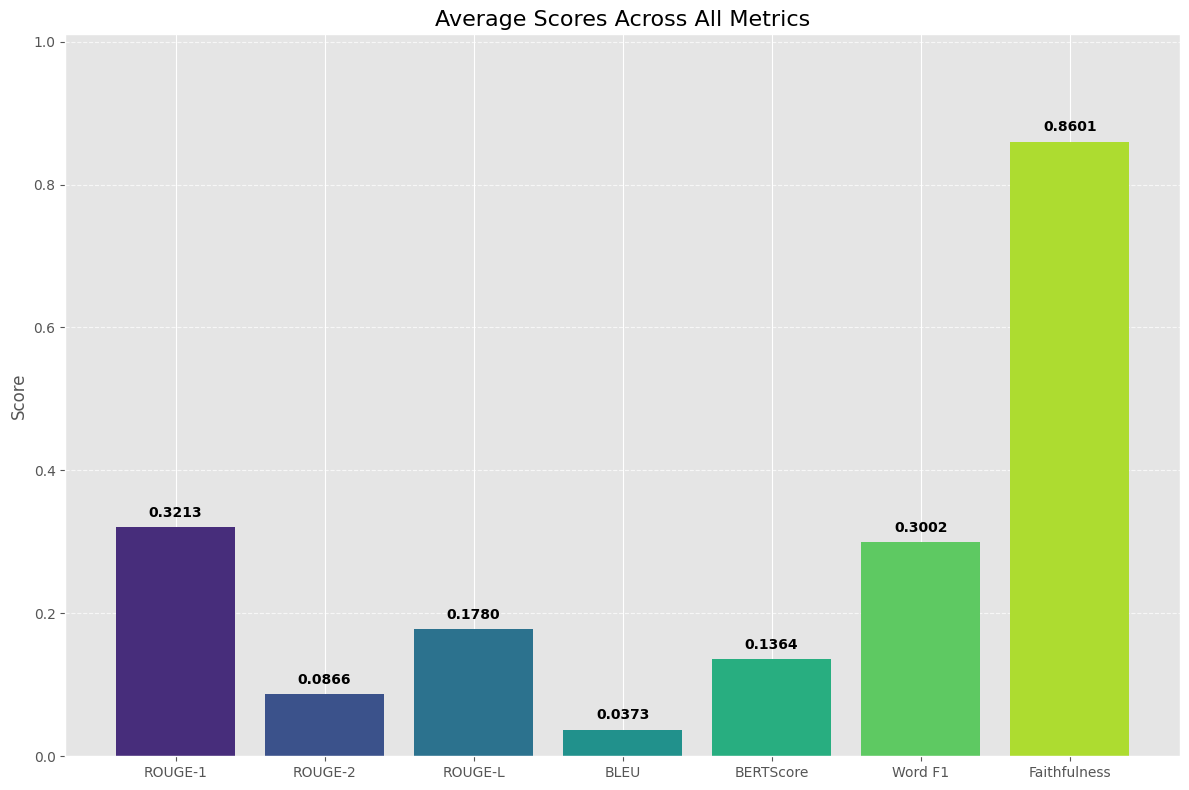

<Figure size 1200x700 with 0 Axes>

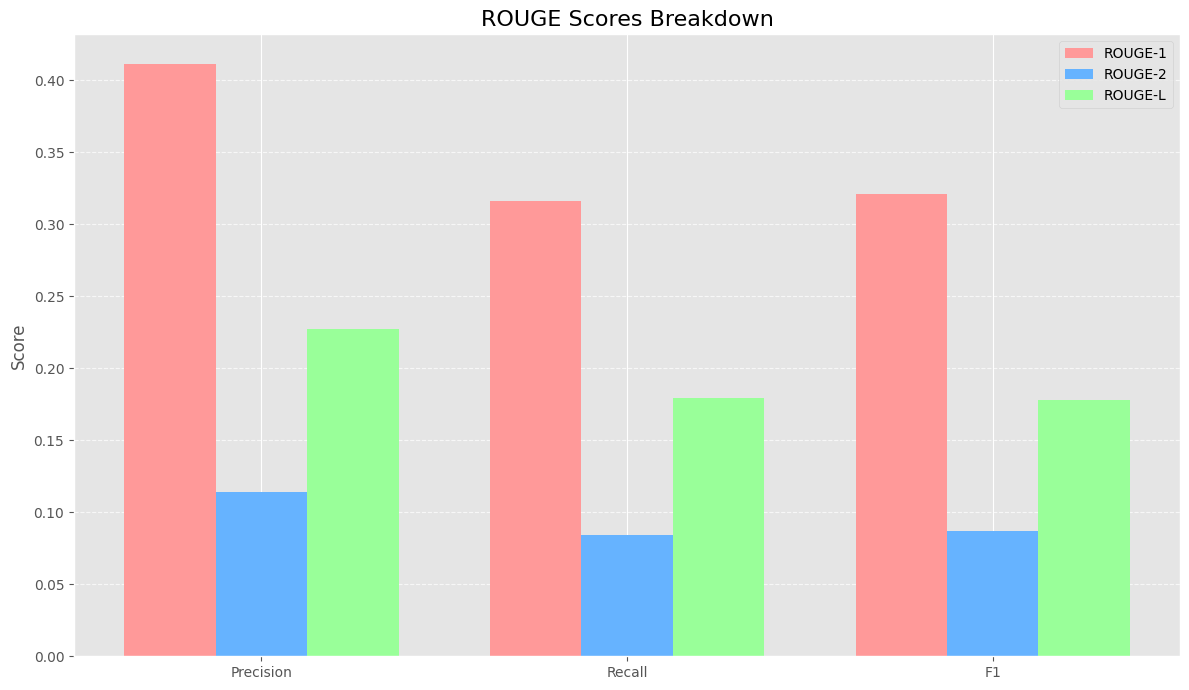

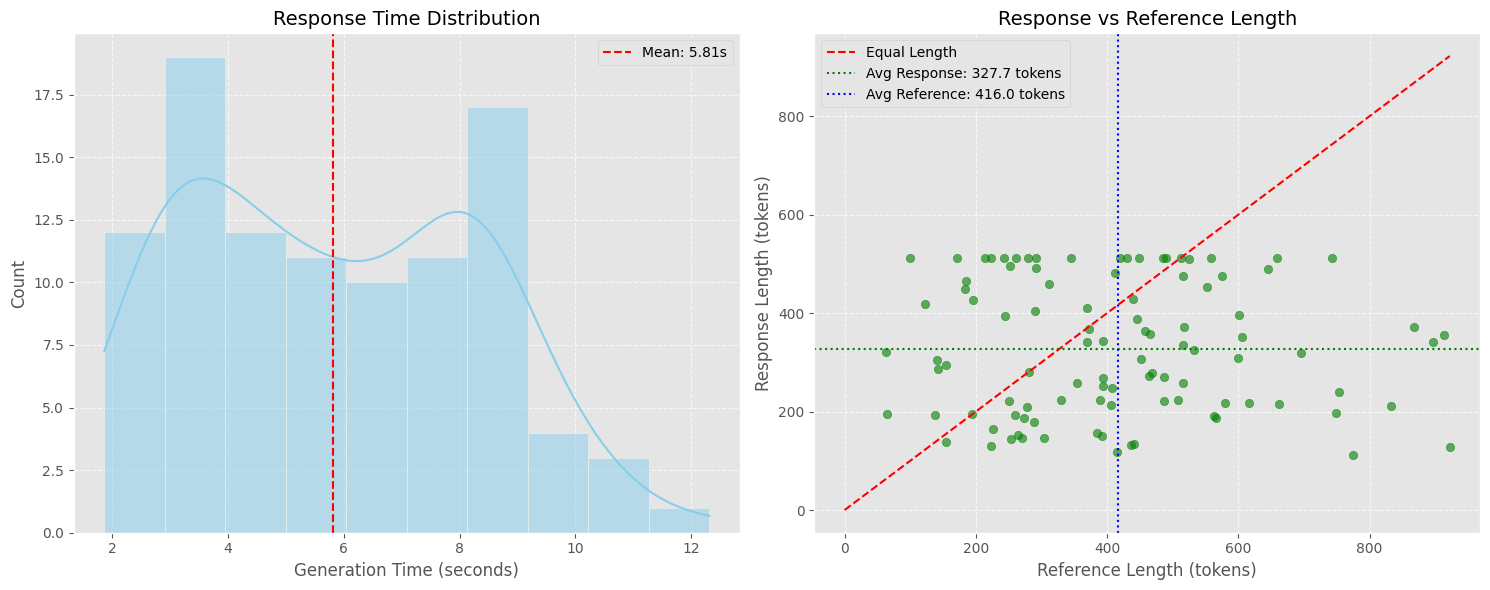

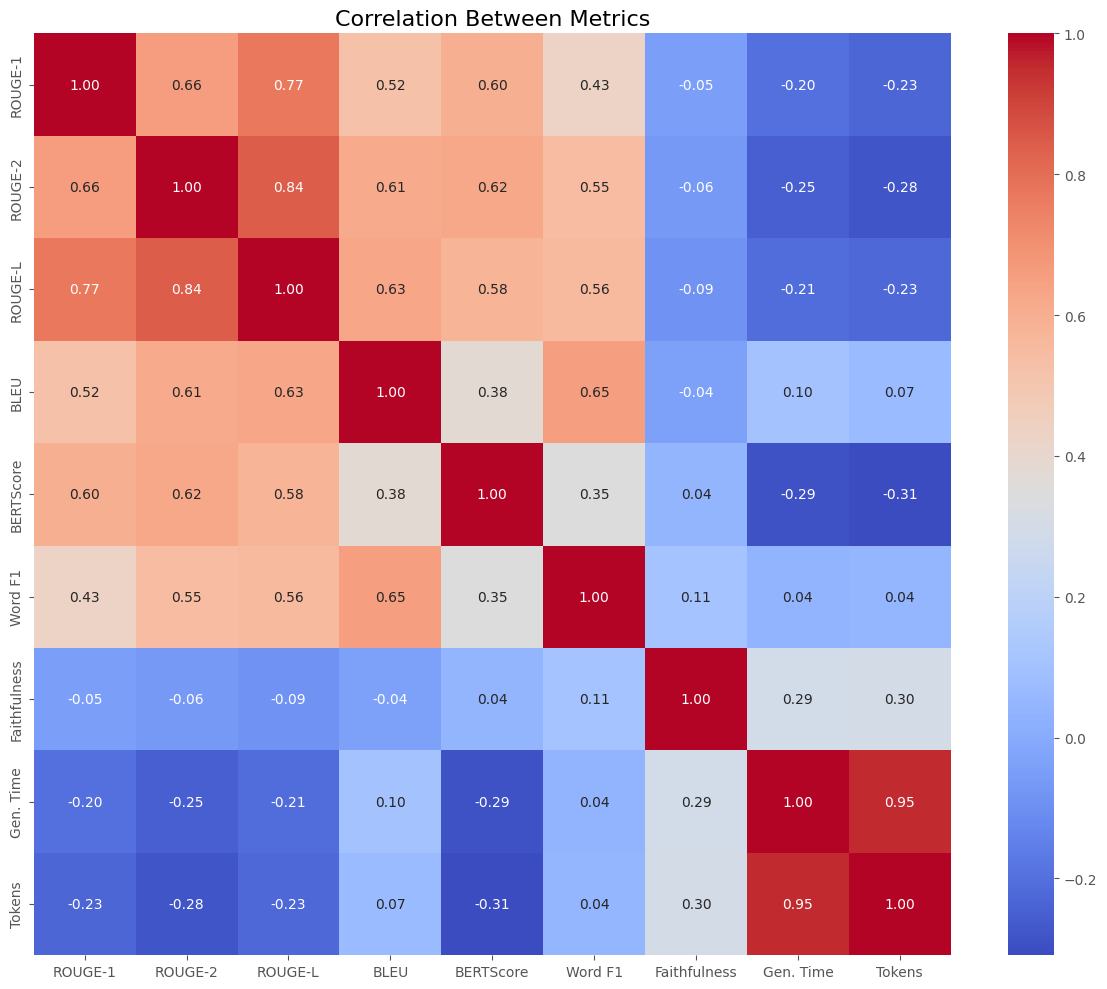


===== SUMMARY STATISTICS =====
ROUGE-1 F1:    0.3213
ROUGE-2 F1:    0.0866
ROUGE-L F1:    0.1780
BLEU:          0.0373
BERTScore:     0.1364
Word F1:       0.3002
Faithfulness:  0.8601
Avg Gen Time:  5.81 seconds
Avg Response:  327.7 tokens
Avg Reference: 416.0 tokens
Tokens Ratio:  0.79x


In [ ]:
# Visualize the results
print("\n===== EVALUATION SUMMARY =====")
summary_stats = visualize_results(results_df)

In [ ]:
# Show examples of good and bad generations
show_examples(results_df, num_examples=2, metric='bert_score')


===== BEST 2 EXAMPLES BY bert_score =====
Question: Je suis travailleur salarié(e). J'accouche plus tôt que prévu. Quelles sont les conséquences sur mon congé de maternité ?
Reference: Avant d’aller plus loin Attention, cette fiche ne concerne que les travailleuses salariées et les chômeuses.Pour les indépendantes, voyez cette fiche "A quelles conditions ai-je droit au congé de ...
Model: assistant
# Answer: Avant d’aller plus loin Attention, cette fiche ne concerne que les travailleurs salariés et les fonctionnaires. Pour les fonctionnaires, voyez notre fiche "A quelles conditions ai-...
Metric (bert_score): 0.3692
Generation Time: 8.67 seconds
Response Tokens: 511
--------------------------------------------------
Question: L'employeur est-il obligé de proposer un plan pour un travail adapté ou pour un autre travail ?
Reference: Avant d’aller plus loin Depuis le 28 novembre 2022, la procédure de rupture du contrat de travail pour force majeure médicale a été modifiée. Non. 